In [52]:
import pandas as pd
import numpy as np
import os

results_dir = "[2] Analyzer Results"

recording_order = [15, 2, 1, 6, 10, 4]# interpulse intervals


prepulse_intensity = {

    "ASR_control":      120,
    "gap_depth":        30,
    "gap_duration_10":  60,
    "gap_duration_20":  60,
    "gap_duration_4":   60,
    "gap_duration_50":  60,
    "gap_duration_8":   60,
    "offset_ASR":       0,
    "offset_PPI_10":    0,
    "offset_PPI_12":    0,
    "offset_PPI_14":    0,
    "offset_PPI_16":    0,
    "offset_PPI_18":    0,
    "offset_PPI_20":    0,
    "offset_PPI_4":     0,
    "offset_PPI_6":     0,
    "offset_PPI_8":     0,
    "offset_PPI_50":    0,
    "tone_in_noise":    80
}
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder']
Fit dataframes: []
Found 13 raw and 0 fit dataframes in [2] Analyzer Results.

Found 18 experiments, 6 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, peakValue, PTPA, PTTA, RMS, AUC
 animal, sex, date, experiment


In [53]:
# Input sex for every animal
sex_dict = {
    "1":    "female",
    "2":    "male",
    "4":    "male",
    "6":    "female",
    "10":   "female",
    "15":   "male"
}

---
Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset
---

In [54]:
# get S from ASR Control
# get PPS from PPI experiments
# get PPSoffset from offset experiments

#calculate %PPI and %PPIoffset

#split all by date and sex

In [55]:
# --- Collect rows for each experiment type, grouped by animal and date ---

def extract_animal(row):
    # Try to get animal from 'animal' column, else from 'experiment' string
    if 'animal' in row and pd.notna(row['animal']):
        return str(row['animal'])
    if 'experiment' in row and isinstance(row['experiment'], str):
        import re
        match = re.search(r'Animal(\d+)', row['experiment'])
        if match:
            return f'Animal{match.group(1)}'
    return None

def average_peakvalue(val):
    # If val is a list, average it; else, convert to float
    if isinstance(val, list):
        floats = []
        for x in val:
            try:
                floats.append(float(x))
            except Exception:
                continue
        return np.nanmean(floats) if floats else np.nan
    try:
        return float(val)
    except Exception:
        # Try to convert from string representation of a list
        if isinstance(val, str) and val.startswith('[') and val.endswith(']'):
            import ast
            try:
                floats = [float(x) for x in ast.literal_eval(val)]
                return np.nanmean(floats) if floats else np.nan
            except Exception:
                return np.nan
        return np.nan
# ...existing code...

def collect_rows(dfs, experiment_filter, startswith=None):
    rows = []
    for df in dfs.values():
        if {'experiment', 'peakValue', 'date'}.issubset(df.columns):
            if startswith:
                mask = df['experiment'].str.startswith(startswith)
            else:
                mask = df['experiment'].isin(experiment_filter)
            for _, row in df[mask].iterrows():
                animal = extract_animal(row)
                if animal:
                    rows.append({
                        'experiment': row['experiment'],
                        'date': row['date'],
                        'animal': animal,
                        'peakValue': average_peakvalue(row['peakValue'])
                    })
    return rows

ctrl_rows   = collect_rows(dfs, ['ASR_control'])
ttn_rows    = collect_rows(dfs, ['tone_in_noise'])
mix_rows    = collect_rows(dfs, [], startswith=None)
gap_rows    = collect_rows(dfs, [], startswith='gap_duration')
offset_rows = collect_rows(dfs, [], startswith='offset_PPI')

# For mix, exclude certain experiments
excluded = {'ASR_control', 'tone_in_noise', 'offset_ASR', 'gap_depth'}
mix_rows = []
for df in dfs.values():
    if {'experiment', 'peakValue', 'date'}.issubset(df.columns):
        mask = ~df['experiment'].isin(excluded)
        for _, row in df[mask].iterrows():
            animal = extract_animal(row)
            if animal:
                mix_rows.append({
                    'experiment': row['experiment'],
                    'date': row['date'],
                    'animal': animal,
                    'peakValue': average_peakvalue(row['peakValue'])
                })

# gap_depth
gap_depth_rows = collect_rows(dfs, ['gap_depth'])

print(f"ASR_control rows: {len(ctrl_rows)}")
print(f"tone_in_noise rows: {len(ttn_rows)}")
print(f"gap_duration rows: {len(gap_rows)}")
print(f"offset_PPI rows: {len(offset_rows)}")
print(f"gap_depth rows: {len(gap_depth_rows)}")

# DataFrames
ctrl_df      = pd.DataFrame(ctrl_rows)
tin_df       = pd.DataFrame(ttn_rows)
gap_df       = pd.DataFrame(gap_rows)
offset_df    = pd.DataFrame(offset_rows)
gd_df        = pd.DataFrame(gap_depth_rows)

ASR_control rows: 86
tone_in_noise rows: 90
gap_duration rows: 432
offset_PPI rows: 882
gap_depth rows: 96


In [56]:
def calc_percent_ppi_per_animal_date(ctrl_df, exp_df, label):
    # Merge on animal and date to align S and PPS
    merged = pd.merge(
        exp_df, ctrl_df,
        on=['animal', 'date'],
        suffixes=('_pps', '_s')
    )
    # Only keep rows with valid peakValues
    merged = merged[pd.notna(merged['peakValue_s']) & pd.notna(merged['peakValue_pps']) & (merged['peakValue_s'] != 0)]
    # Calculate %PPI as 100 * (S - PPS) / S
    merged['percent_ppi'] = 100 * (merged['peakValue_s'] - merged['peakValue_pps']) / merged['peakValue_s']
    print(f"\n{label}:")
    print(merged[['animal', 'date', 'percent_ppi']])
    return merged[['animal', 'date', 'percent_ppi']]

# Calculate %PPI for each experiment type
ppi_tin = calc_percent_ppi_per_animal_date(ctrl_df, tin_df, "tone_in_noise")
ppi_gap = calc_percent_ppi_per_animal_date(ctrl_df, gap_df, "gap_duration")
ppi_offset = calc_percent_ppi_per_animal_date(ctrl_df, offset_df, "offset_PPI")
ppi_gd = calc_percent_ppi_per_animal_date(ctrl_df, gd_df, "gap_depth")


tone_in_noise:
       animal     date  percent_ppi
0     Animal1  April16     9.179688
1     Animal1  April16     9.179688
2     Animal1  April16     9.179688
3     Animal1  April16     9.179688
4     Animal2  April16    33.593750
..        ...      ...          ...
427   Animal4    May20    25.773196
428  Animal15    May20     0.000000
429  Animal15    May20     0.000000
430  Animal15    May20     0.000000
431  Animal15    May20     0.000000

[432 rows x 3 columns]

gap_duration:
        animal     date  percent_ppi
0      Animal1  April16    -5.468750
1      Animal1  April16    -5.468750
2      Animal1  April16    -5.468750
3      Animal1  April16    -5.468750
4      Animal1  April16    21.093750
...        ...      ...          ...
2055  Animal15    May20     4.054054
2056  Animal15    May20   -50.000000
2057  Animal15    May20   -50.000000
2058  Animal15    May20   -50.000000
2059  Animal15    May20   -50.000000

[2060 rows x 3 columns]

offset_PPI:
        animal     date  percen

---

In [57]:
def add_sex_column(ppi_df):
    # Add a 'sex' column using the sex_dict
    ppi_df = ppi_df.copy()
    ppi_df['sex'] = ppi_df['animal'].str.extract(r'(\d+)')[0].map(sex_dict)
    return ppi_df

def print_ppi_stats(ppi_df, label):
    # Calculate averages by sex and overall
    avg_male = ppi_df[ppi_df['sex'] == 'male']['percent_ppi'].mean()
    avg_female = ppi_df[ppi_df['sex'] == 'female']['percent_ppi'].mean()
    avg_overall = ppi_df['percent_ppi'].mean()
    print(f"\n{label} averages:")
    print(f"  Male:   {avg_male:.2f}")
    print(f"  Female: {avg_female:.2f}")
    print(f"  Overall:{avg_overall:.2f}")

# Add sex column to each %PPI dataframe
ppi_tin_sex = add_sex_column(ppi_tin)
ppi_gap_sex = add_sex_column(ppi_gap)
ppi_offset_sex = add_sex_column(ppi_offset)
ppi_gd_sex = add_sex_column(ppi_gd)

# Print averages
print_ppi_stats(ppi_tin_sex, "tone_in_noise")
print_ppi_stats(ppi_gap_sex, "gap_duration")
print_ppi_stats(ppi_offset_sex, "offset_PPI")
print_ppi_stats(ppi_gd_sex, "gap_depth")


tone_in_noise averages:
  Male:   20.78
  Female: 26.56
  Overall:23.83

gap_duration averages:
  Male:   -2.41
  Female: 0.78
  Overall:-0.71

offset_PPI averages:
  Male:   11.45
  Female: 11.42
  Overall:11.44

gap_depth averages:
  Male:   -11.39
  Female: 0.22
  Overall:-5.38


In [58]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def test_sex_difference(ppi_df, label):
    male = ppi_df[ppi_df['sex'] == 'male']['percent_ppi'].dropna()
    female = ppi_df[ppi_df['sex'] == 'female']['percent_ppi'].dropna()
    print(f"\n{label} - Shapiro-Wilk normality test:")
    stat_m, p_m = shapiro(male)
    stat_f, p_f = shapiro(female)
    print(f"  Male:   W={stat_m:.3f}, p={p_m:.3f}")
    print(f"  Female: W={stat_f:.3f}, p={p_f:.3f}")
    # If both groups are normal, use t-test; else, use Mann-Whitney U
    if p_m > 0.05 and p_f > 0.05:
        stat, p = ttest_ind(male, female, nan_policy='omit')
        print("  Parametric t-test:")
    else:
        stat, p = mannwhitneyu(male, female, alternative='two-sided')
        print("  Non-parametric Mann-Whitney U test:")
    print(f"  Statistic={stat:.3f}, p={p:.3f}")

# Run for each experiment
test_sex_difference(ppi_tin_sex, "tone_in_noise")
test_sex_difference(ppi_gap_sex, "gap_duration")
test_sex_difference(ppi_offset_sex, "offset_PPI")
test_sex_difference(ppi_gd_sex, "gap_depth")


tone_in_noise - Shapiro-Wilk normality test:
  Male:   W=0.735, p=0.000
  Female: W=0.953, p=0.000
  Non-parametric Mann-Whitney U test:
  Statistic=21600.000, p=0.201

gap_duration - Shapiro-Wilk normality test:
  Male:   W=0.763, p=0.000
  Female: W=0.941, p=0.000
  Non-parametric Mann-Whitney U test:
  Statistic=508568.000, p=0.144

offset_PPI - Shapiro-Wilk normality test:
  Male:   W=0.952, p=0.000
  Female: W=0.944, p=0.000
  Non-parametric Mann-Whitney U test:
  Statistic=2132168.000, p=0.114

gap_depth - Shapiro-Wilk normality test:
  Male:   W=0.910, p=0.000
  Female: W=0.903, p=0.000
  Non-parametric Mann-Whitney U test:
  Statistic=17072.000, p=0.000


In [59]:
from scipy.stats import mannwhitneyu

def gap_depth_effect_strength(ppi_df):
    male = ppi_df[ppi_df['sex'] == 'male']['percent_ppi'].dropna()
    female = ppi_df[ppi_df['sex'] == 'female']['percent_ppi'].dropna()
    u_stat, p_val = mannwhitneyu(male, female, alternative='two-sided')
    # Rank-biserial correlation: r = 1 - (2U) / (n1*n2)
    n1, n2 = len(male), len(female)
    rbc = 1 - (2 * u_stat) / (n1 * n2)
    print("\ngap_depth effect strength:")
    print(f"  Male mean:   {male.mean():.2f}")
    print(f"  Female mean: {female.mean():.2f}")
    print(f"  Mann-Whitney U statistic: {u_stat:.0f}, p-value: {p_val:.3g}")
    print(f"  Rank-biserial correlation (effect size): {rbc:.3f}")

gap_depth_effect_strength(ppi_gd_sex)


gap_depth effect strength:
  Male mean:   -11.39
  Female mean: 0.22
  Mann-Whitney U statistic: 17072, p-value: 2.58e-10
  Rank-biserial correlation (effect size): 0.342


---

In [60]:
import re
from scipy.stats import kruskal

def extract_trailing_number(exp_name):
    # Extract trailing number from experiment name (e.g., gap_duration_10 -> 10)
    match = re.search(r'_(\d+)$', exp_name)
    return int(match.group(1)) if match else None

def add_trailing_number_column(df, exp_prefix):
    df = df.copy()
    df['trailing_number'] = df['experiment'].apply(
        lambda x: extract_trailing_number(x) if x.startswith(exp_prefix) else None
    )
    return df.dropna(subset=['trailing_number'])

# Prepare gap_duration and offset_PPI dataframes with trailing number
gap_df_num = add_trailing_number_column(gap_df, 'gap_duration')
offset_df_num = add_trailing_number_column(offset_df, 'offset_PPI')

def test_trailing_number_effect(ppi_df, label):
    groups = []
    numbers = sorted(ppi_df['trailing_number'].unique())
    print(f"\n{label} - Kruskal-Wallis test for trailing number effect on %PPI:")
    for num in numbers:
        vals = ppi_df[ppi_df['trailing_number'] == num]['percent_ppi'].dropna()
        groups.append(vals)
        print(f"  {label} {num}: n={len(vals)}, mean={vals.mean():.2f}")
    if len(groups) > 1:
        stat, p = kruskal(*groups)
        print(f"  Kruskal-Wallis statistic={stat:.3f}, p={p:.3g}")
    else:
        print("  Not enough groups for test.")

# Calculate %PPI for gap_duration and offset_PPI with trailing number
gap_ppi = pd.merge(gap_df_num, ctrl_df, on=['animal', 'date'], suffixes=('_pps', '_s'))
gap_ppi = gap_ppi[pd.notna(gap_ppi['peakValue_s']) & pd.notna(gap_ppi['peakValue_pps']) & (gap_ppi['peakValue_s'] != 0)]
gap_ppi['percent_ppi'] = 100 * (gap_ppi['peakValue_s'] - gap_ppi['peakValue_pps']) / gap_ppi['peakValue_s']

offset_ppi = pd.merge(offset_df_num, ctrl_df, on=['animal', 'date'], suffixes=('_pps', '_s'))
offset_ppi = offset_ppi[pd.notna(offset_ppi['peakValue_s']) & pd.notna(offset_ppi['peakValue_pps']) & (offset_ppi['peakValue_s'] != 0)]
offset_ppi['percent_ppi'] = 100 * (offset_ppi['peakValue_s'] - offset_ppi['peakValue_pps']) / offset_ppi['peakValue_s']

# Run tests
test_trailing_number_effect(gap_ppi, "gap_duration")
test_trailing_number_effect(offset_ppi, "offset_PPI")


gap_duration - Kruskal-Wallis test for trailing number effect on %PPI:
  gap_duration 4: n=408, mean=-4.80
  gap_duration 8: n=396, mean=-2.61
  gap_duration 10: n=436, mean=1.68
  gap_duration 20: n=436, mean=0.26
  gap_duration 50: n=384, mean=1.78
  Kruskal-Wallis statistic=43.827, p=6.97e-09

offset_PPI - Kruskal-Wallis test for trailing number effect on %PPI:
  offset_PPI 4: n=444, mean=9.32
  offset_PPI 6: n=416, mean=11.54
  offset_PPI 8: n=376, mean=13.63
  offset_PPI 10: n=436, mean=13.42
  offset_PPI 12: n=408, mean=13.81
  offset_PPI 14: n=396, mean=7.43
  offset_PPI 16: n=440, mean=14.83
  offset_PPI 18: n=428, mean=13.21
  offset_PPI 20: n=412, mean=14.55
  offset_PPI 50: n=444, mean=3.09
  Kruskal-Wallis statistic=100.050, p=1.54e-17


In [61]:
from scipy.stats import spearmanr

def test_trailing_number_direction_and_strength(ppi_df, label):
    # Test if %PPI increases or decreases with trailing number (treated as continuous)
    vals = ppi_df[['trailing_number', 'percent_ppi']].dropna()
    corr, p = spearmanr(vals['trailing_number'], vals['percent_ppi'])
    print(f"\n{label} trailing number direction (Spearman correlation):")
    print(f"  Spearman r = {corr:.3f}, p = {p:.3g}")
    if p < 0.05:
        direction = "increases" if corr > 0 else "decreases"
        print(f"  %PPI {direction} with trailing number.")
    else:
        print("  No significant monotonic relationship.")
    # Effect strength: absolute value of correlation coefficient
    print(f"  Effect strength (|r|): {abs(corr):.3f}")

test_trailing_number_direction_and_strength(gap_ppi, "gap_duration")
test_trailing_number_direction_and_strength(offset_ppi, "offset_PPI")


gap_duration trailing number direction (Spearman correlation):
  Spearman r = 0.111, p = 4.8e-07
  %PPI increases with trailing number.
  Effect strength (|r|): 0.111

offset_PPI trailing number direction (Spearman correlation):
  Spearman r = -0.037, p = 0.0176
  %PPI decreases with trailing number.
  Effect strength (|r|): 0.037


---

In [62]:
# Use the raw data to keep gap/offset length info intact in the combined dataframe

# Add trailing_number to gap_df and offset_df directly from their experiment names
def extract_trailing_number(exp_name):
    import re
    match = re.search(r'_(\d+)$', exp_name)
    return int(match.group(1)) if match else None

gap_df = gap_df.copy()
gap_df['trailing_number'] = gap_df['experiment'].apply(lambda x: extract_trailing_number(x))
offset_df = offset_df.copy()
offset_df['trailing_number'] = offset_df['experiment'].apply(lambda x: extract_trailing_number(x))

# Calculate %PPI for each experiment type, keeping trailing_number for gap/offset
def calc_percent_ppi_per_animal_date_full(ctrl_df, exp_df, label):
    merged = pd.merge(
        exp_df, ctrl_df,
        on=['animal', 'date'],
        suffixes=('_pps', '_s')
    )
    merged = merged[pd.notna(merged['peakValue_s']) & pd.notna(merged['peakValue_pps']) & (merged['peakValue_s'] != 0)]
    merged['percent_ppi'] = 100 * (merged['peakValue_s'] - merged['peakValue_pps']) / merged['peakValue_s']
    merged['experiment'] = label
    # If trailing_number exists, keep it
    if 'trailing_number' in exp_df.columns:
        merged['trailing_number'] = merged['trailing_number']
    else:
        merged['trailing_number'] = None
    return merged

ppi_tin = calc_percent_ppi_per_animal_date_full(ctrl_df, tin_df, "tone_in_noise")
ppi_gap = calc_percent_ppi_per_animal_date_full(ctrl_df, gap_df, "gap_duration")
ppi_offset = calc_percent_ppi_per_animal_date_full(ctrl_df, offset_df, "offset_PPI")
ppi_gd = calc_percent_ppi_per_animal_date_full(ctrl_df, gd_df, "gap_depth")

all_ppi = pd.concat([ppi_tin, ppi_gap, ppi_offset, ppi_gd], ignore_index=True)

print(all_ppi)

     experiment_pps     date    animal  peakValue_pps experiment_s  \
0     tone_in_noise  April16   Animal1          23.25  ASR_control   
1     tone_in_noise  April16   Animal1          23.25  ASR_control   
2     tone_in_noise  April16   Animal1          23.25  ASR_control   
3     tone_in_noise  April16   Animal1          23.25  ASR_control   
4     tone_in_noise  April16   Animal2          51.00  ASR_control   
...             ...      ...       ...            ...          ...   
7143      gap_depth    May20   Animal6          62.00  ASR_control   
7144      gap_depth    May20  Animal15          93.00  ASR_control   
7145      gap_depth    May20  Animal15          93.00  ASR_control   
7146      gap_depth    May20  Animal15          93.00  ASR_control   
7147      gap_depth    May20  Animal15          93.00  ASR_control   

      peakValue_s  percent_ppi     experiment trailing_number  
0            25.6     9.179688  tone_in_noise            None  
1            25.6     9.179688 

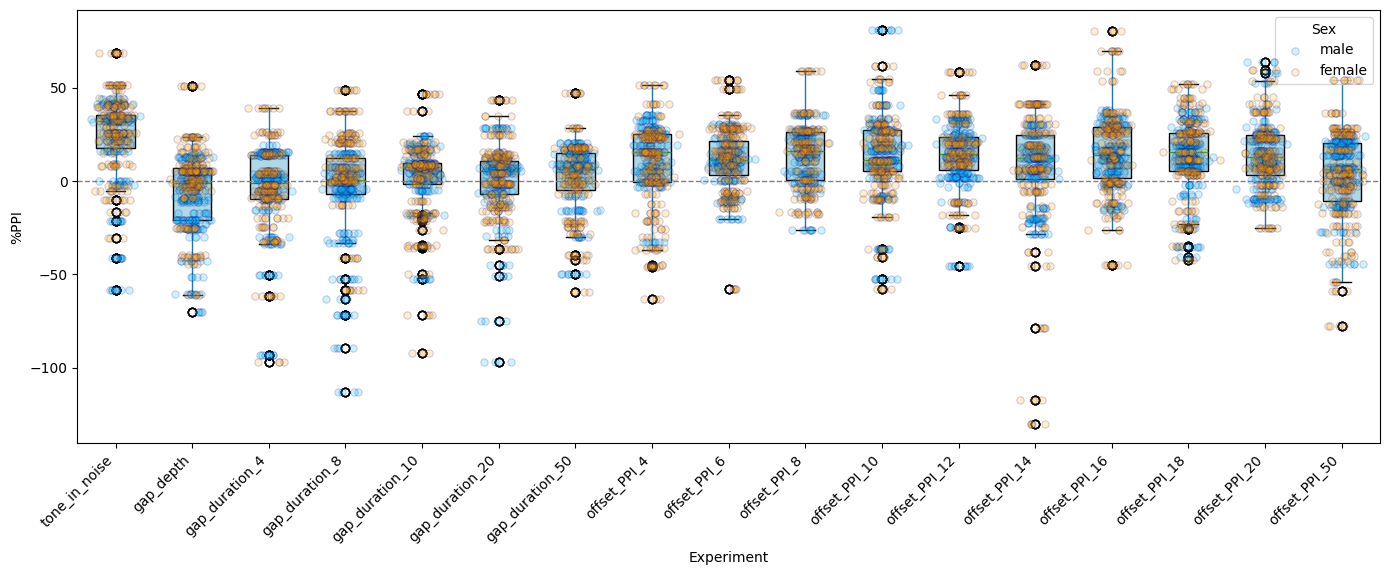

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import re

# Use all_ppi as the source DataFrame

def experiment_sort_key(exp):
    if exp == "tone_in_noise":
        return (0, 0)
    if exp == "gap_depth":
        return (1, 0)
    m_gap = re.match(r"gap_duration_(\d+)", exp)
    m_offset = re.match(r"offset_PPI_(\d+)", exp)
    if m_gap:
        return (2, int(m_gap.group(1)))
    elif m_offset:
        return (3, int(m_offset.group(1)))
    else:
        return (4, exp)

# Add sex column using sex_dict and animal number
def add_sex_column(df):
    df = df.copy()
    df['animal_num'] = df['animal'].str.extract(r'(\d+)')[0]
    df['sex'] = df['animal_num'].map(sex_dict)
    return df

all_ppi_plot = add_sex_column(all_ppi.copy())
if 'trailing_number' in all_ppi_plot.columns:
    all_ppi_plot['experiment_full'] = all_ppi_plot.apply(
        lambda row: f"{row['experiment']}_{int(row['trailing_number'])}" if pd.notna(row['trailing_number']) else row['experiment'],
        axis=1
    )
else:
    all_ppi_plot['experiment_full'] = all_ppi_plot['experiment']

experiment_order = sorted(all_ppi_plot['experiment_full'].unique(), key=experiment_sort_key)
all_ppi_plot['experiment_full'] = pd.Categorical(all_ppi_plot['experiment_full'], categories=experiment_order, ordered=True)

plt.figure(figsize=(14, 6))
ax = plt.gca()

# Boxplot
all_ppi_plot.boxplot(column="percent_ppi", by="experiment_full", ax=ax, grid=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))

# Scatterplot overlay with male/female colors
color_map = {'male': 'deepskyblue', 'female': 'orange'}
for i, exp in enumerate(experiment_order, start=1):
    exp_data = all_ppi_plot[all_ppi_plot["experiment_full"] == exp]
    for sex, color in color_map.items():
        yvals = exp_data[exp_data['sex'] == sex]["percent_ppi"]
        xvals = i + 0.1 * (np.random.randn(len(yvals)))
        ax.scatter(
            xvals, yvals,
            color=color,
            edgecolor="navy",
            alpha=0.20,
            s=28,
            linewidth=0.7,
            marker='o',
            zorder=10,
            label=sex if i == 1 else None  # Only label once for legend
        )

plt.ylabel("%PPI")
plt.xlabel("Experiment")
plt.suptitle("")
plt.title("")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(ticks=range(1, len(experiment_order)+1), labels=experiment_order, rotation=45, ha='right')
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Sex", loc="upper right")
plt.tight_layout()
plt.show()

Average trendline slope: 0.1613
Tone in noise trendline slope: 3.8907
Gap depth trendline slope: 2.0059


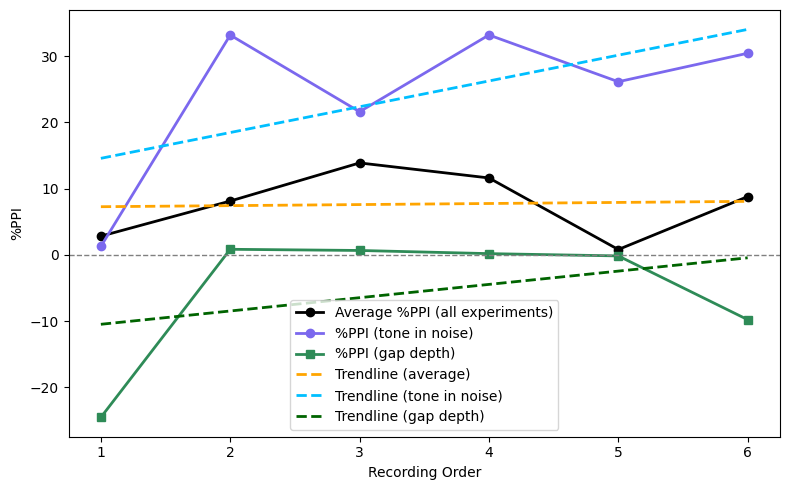

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Use all_ppi as the source DataFrame
recording_order = [15, 2, 1, 6, 10, 4]
animal_order = [f'Animal{num}' for num in recording_order]

def extract_animal(row):
    if 'animal' in row and pd.notna(row['animal']):
        return str(row['animal'])
    if 'experiment' in row and isinstance(row['experiment'], str):
        import re
        match = re.search(r'Animal(\d+)', row['experiment'])
        if match:
            return f'Animal{match.group(1)}'
    return None

# Average %PPI per animal for each experiment type
def avg_ppi_per_animal(df, experiment_label=None):
    df = df.copy()
    if experiment_label is not None:
        df = df[df['experiment'] == experiment_label]
    df['animal_id'] = df.apply(extract_animal, axis=1)
    grouped = df.groupby('animal_id')['percent_ppi'].mean()
    return {animal: grouped[animal] for animal in animal_order if animal in grouped}

# All experiments (average per animal)
all_ppi_animals = all_ppi.copy()
all_ppi_animals['animal_id'] = all_ppi_animals.apply(extract_animal, axis=1)
avg_ppi_all = all_ppi_animals.groupby('animal_id')['percent_ppi'].mean()
sorted_ppi = [avg_ppi_all[a] for a in animal_order if a in avg_ppi_all]

# Tone in noise
avg_ppi_ttn = avg_ppi_per_animal(all_ppi, 'tone_in_noise')
sorted_ppi_ttn = [avg_ppi_ttn[a] for a in animal_order if a in avg_ppi_ttn]

# Gap depth
avg_ppi_gap_depth = avg_ppi_per_animal(all_ppi, 'gap_depth')
sorted_ppi_gap_depth = [avg_ppi_gap_depth[a] for a in animal_order if a in avg_ppi_gap_depth]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_ppi)+1), sorted_ppi, marker='o', color='black', linewidth=2, label='Average %PPI (all experiments)')
plt.plot(range(1, len(sorted_ppi_ttn)+1), sorted_ppi_ttn, marker='o', color='mediumslateblue', linewidth=2, label='%PPI (tone in noise)')
plt.plot(range(1, len(sorted_ppi_gap_depth)+1), sorted_ppi_gap_depth, marker='s', color='seagreen', linewidth=2, label='%PPI (gap depth)')
plt.ylabel('%PPI')
plt.xlabel('Recording Order')
plt.title('')
plt.xticks(ticks=range(1, len(animal_order)+1), labels=[str(i) for i in range(1, len(animal_order)+1)])
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Add trendlines and print slopes
if len(sorted_ppi) > 1:
    x = np.arange(1, len(sorted_ppi)+1)
    z = np.polyfit(x, sorted_ppi, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), color='orange', linestyle='--', linewidth=2, label='Trendline (average)')
    print(f"Average trendline slope: {z[0]:.4f}")

if len(sorted_ppi_ttn) > 1:
    x = np.arange(1, len(sorted_ppi_ttn)+1)
    z_ttn = np.polyfit(x, sorted_ppi_ttn, 1)
    p_ttn = np.poly1d(z_ttn)
    plt.plot(x, p_ttn(x), color='deepskyblue', linestyle='--', linewidth=2, label='Trendline (tone in noise)')
    print(f"Tone in noise trendline slope: {z_ttn[0]:.4f}")

if len(sorted_ppi_gap_depth) > 1:
    x = np.arange(1, len(sorted_ppi_gap_depth)+1)
    z_gap = np.polyfit(x, sorted_ppi_gap_depth, 1)
    p_gap = np.poly1d(z_gap)
    plt.plot(x, p_gap(x), color='darkgreen', linestyle='--', linewidth=2, label='Trendline (gap depth)')
    print(f"Gap depth trendline slope: {z_gap[0]:.4f}")

plt.legend()
plt.tight_layout()
plt.show()